In [1]:
# if packages are missing, please uncomment the lines below and run cell
# Installed torch separately since this torch doesnt support cuda so i dont wanna accidentally download it and disable my cuda when testing requirements.txt
# %pip install -r ./requirements.txt
# %pip install torch==2.3.0+cpu

In [14]:
%pip show safetensors

Name: safetensors
Version: 0.6.2
Summary: 
Home-page: https://github.com/huggingface/safetensors
Author: 
Author-email: Nicolas Patry <patry.nicolas@protonmail.com>
License: 
Location: c:\Users\kyeyo\OneDrive\Desktop\SC4001\Group Assignment\venv\Lib\site-packages
Requires: 
Required-by: timm
Note: you may need to restart the kernel to use updated packages.


In [15]:
import itertools
import json
import os
import threading
from collections.abc import Callable, Iterable
from enum import Enum, auto

import matplotlib.pyplot as plt
import numpy as np
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from safetensors.torch import load_file as safe_load
from baseline_model import get_flowers_dataloaders, set_seed, train_epoch, validate
from connection_test import hugging_face_connectivity_test
from tqdm.notebook import tqdm
from typing import Any, Optional, Sequence

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed()
train_loader, val_loader, test_loader = get_flowers_dataloaders(batch_size=32)
print(device)

Seed set to 42


cuda


### Model creation, significant overlap with baseline_model

In [16]:
def freeze_head(model, model_name):
	if "vit" in model_name:
		for name, param in model.named_parameters():
			if not name.startswith("head"):  # ViT classifier head
				param.requires_grad = False
	elif "resnet" in model_name:
		for name, param in model.named_parameters():
			if "fc" not in name:  # 'fc' is the final classifier for resnets
				param.requires_grad = False
	else:
		raise NotImplementedError(
			f"Freeze head received unknown model type {model_name}"
		)
	return model


def create_model_with_timeout(model_name, num_classes, device, timeout=10):
	"""
	Create a timm model safely with timeout and fallback logic.
	Tries local weights first, then checks Hugging Face and retries online if accessible.
	"""
	model_container = {}

	def target():
		try:
			model = timm.create_model(
				model_name, pretrained=False, num_classes=num_classes
			)

			# --- Locate local weights ---
			weights_dir = os.path.join("..", "original_weights")
			safe_path = os.path.join(weights_dir, f"{model_name}.safetensors")
			pth_path = os.path.join(weights_dir, f"{model_name}.pth")

			if os.path.exists(safe_path):
				weight_path = safe_path
			elif os.path.exists(pth_path):
				weight_path = pth_path
			else:
				raise FileNotFoundError(
					f"No local weight file found for '{model_name}' in '{weights_dir}'"
				)

			# --- Load local weights safely ---
			try:
				if weight_path.endswith(".safetensors"):
					state_dict = safe_load(weight_path)
				else:
					# PyTorch .pth / .pt file
					state_dict = torch.load(
						weight_path, map_location="cpu", weights_only=False
					)
			except Exception as e:
				raise RuntimeError(
					f"Error loading local weight file '{weight_path}': {e}"
				)

			# --- Apply weights ---
			try:
				checkpoint = state_dict.copy()
				for key in list(checkpoint.keys()):
					if key.startswith("fc.") or key.startswith("head."):
						del checkpoint[key]

				# Now load safely
				missing, unexpected = model.load_state_dict(checkpoint, strict=False)
				print(
					f"Ignored missing keys: {missing}"
				)  # should include 'fc.weight', 'fc.bias'
				print(f"Ignored unexpected keys: {unexpected}")
			except Exception as e:
				raise RuntimeError(f"Weight mismatch for '{model_name}': {e}")

			# --- Move to device ---
			model_container["model"] = model.to(device)

		except Exception as e:
			model_container["error"] = str(e)

	# --- Run model creation in separate thread with timeout ---
	thread = threading.Thread(target=target)
	thread.start()
	thread.join(timeout)

	if thread.is_alive():
		raise TimeoutError(f"Creating model '{model_name}' timed out after {timeout}s.")

	# --- Handle failure: fallback path ---
	if "error" in model_container:
		print(f"Local load failed: {model_container['error']}")

		try:
			print("\n")
			hf_status = hugging_face_connectivity_test()
		except Exception as e:
			raise RuntimeError(f"Hugging Face connectivity test failed to run: {e}")

		# interpret test output if no connection
		if not hf_status:
			raise RuntimeError(
				"Local Weights not found and could not reach Hugging Face. Check your DNS, VPN, or network access."
			)

		# --- Retry with online download ---
		print("Retrying model creation via TIMM (pretrained=True)...")
		try:
			model = timm.create_model(
				model_name, pretrained=True, num_classes=num_classes
			)
			model_container["model"] = model.to(device)
			print(
				f"✅ Successfully downloaded and loaded '{model_name}' from Hugging Face."
			)
		except Exception as e:
			raise RuntimeError(
				f"Retried online download but still failed for '{model_name}': {e}"
			)

	model_container["model"] = freeze_head(model_container["model"], model_name)
	return model_container["model"]

# Different Depths

In [ ]:
class EarlyStopper:
	def __init__(self, patience=10, min_delta=0):
		self.patience = patience
		self.min_delta = min_delta
		self.counter = 0
		self.min_validation_loss = np.inf

	def __call__(self, validation_loss):
		if validation_loss < self.min_validation_loss:
			self.min_validation_loss = validation_loss
			self.counter = 0
		elif validation_loss > (self.min_validation_loss + self.min_delta):
			self.counter += 1
			if self.counter >= self.patience:
				return True
		return False

In [ ]:
def get_performance(
	model_name: str,
	num_classes: int = 102,
	num_epochs: int = 30,
	batch_size: int = 32,
	lr: float = 0.001,
	weight_decay: float = 1e-4,
	scheduler_step_size: int = 10,
	scheduler_gamma: float = 0.1,
	device: str = "cuda" if torch.cuda.is_available() else "cpu",
	model_transform: Callable[[nn.Module], nn.Module] | None = None,
):
	"""
	Train and evaluate any timm model (ViT, ResNet, etc.).
	"""
	# === 1. Setup ===
	history = {
		"train_loss": [],
		"train_acc": [],
		"val_loss": [],
		"val_acc": [],
		"test_loss": float,
		"test_acc": float,
	}
	best_val_acc = 0.0
	best_model_state = None
	early_stop = EarlyStopper()

	# === 2. Create model ===
	model = create_model_with_timeout(
		model_name, num_classes=num_classes, device=device
	)
	if model_transform is not None:
		model = model_transform(model)

	criterion = nn.CrossEntropyLoss().to(device)
	optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
	scheduler = optim.lr_scheduler.StepLR(
		optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma
	)

	assert num_epochs > 0, "Num epochs must be greater than 0!"

	# === 3. Training Loop ===
	for epoch in tqdm(
		range(num_epochs), desc=f"Training Epochs ({model_name})", unit="epoch"
	):
		current_lr = scheduler.get_last_lr()[0]

		train_loss, train_acc = train_epoch(
			model, train_loader, criterion, optimizer, device
		)
		val_loss, val_acc = validate(model, val_loader, criterion, device)
		scheduler.step()

		# Record metrics
		for key, val in zip(
			["train_loss", "train_acc", "val_loss", "val_acc"],
			[train_loss, train_acc, val_loss, val_acc],
		):
			history[key].append(val)

		# Save best model
		if val_acc > best_val_acc:
			best_val_acc = val_acc
			best_model_state = model.state_dict().copy()

		if early_stop(val_loss):
			tqdm.write("Early stopping triggered.")
			break

		tqdm.write(
			f"Epoch [{epoch + 1}/{num_epochs}] "
			f"LR: {current_lr:.6f} | "
			f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
			f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%"
		)

	# === 4. Test Evaluation ===
	test_loss, test_acc = validate(
		model, test_loader, criterion, device, valid_or_test="test"
	)
	history["test_loss"] = test_loss
	history["test_acc"] = test_acc

	assert best_val_acc > 0.0 and best_model_state is not None, (
		"The model validation accuracy is 0! Check your data or training loop."
	)

	model.load_state_dict(best_model_state)
	print(f"\nBest Validation Accuracy: {best_val_acc:.2f}%")
	print(f"\nTest Accuracy: {test_acc:.2f}%")

	num_params = sum(p.numel() for p in model.parameters())
	history["num_params"] = num_params
	return model, history, num_params

### Model Sources and Experiment Setup

If you need to **download the models manually**, here are the sources:

- [ResNet18](https://huggingface.co/timm/resnet18.tv_in1k/tree/main)  
- [ResNet34](https://huggingface.co/timm/resnet34.tv_in1k/tree/main)  
- [ResNet50](https://huggingface.co/timm/resnet50.tv_in1k/tree/main)  
- [ResNet101](https://huggingface.co/timm/resnet101.tv_in1k/tree/main)  
- [ResNet152](https://huggingface.co/timm/resnet152.tv_in1k/tree/main)  
- [ViT Base Patch32 (ImageNet-21k)](https://huggingface.co/timm/vit_base_patch32_224.orig_in21k/tree/main)  
- [ViT Base Patch16 (ImageNet-21k)](https://huggingface.co/timm/vit_base_patch16_224.orig_in21k/tree/main)

---

#### Notes
- **ResNet memory** scales *linearly* with the number of layers — this is because intermediate activations must be stored for backpropagation.  
	> My 7.6 GB GPU should handle all ResNet variants; your GPU may differ
- **ViT memory** scales *quadratically* (roughly inversely with patch size).  
	> My GPU likely cannot handle `vit_large` or `vit_huge`.
- **Training datasets differ:**
	- ResNets use **ImageNet-1k**
	- ViTs use **ImageNet-21k**
- Chosen ViT models are ones without heavy modern augmentations, for a fairer comparison.

---


In [ ]:
# === Model Setup ===
resnet_histories = {}

# Default list for full experiments
model_names_default = [
	"resnet18",
	"resnet34",
	"resnet50",
	"resnet101",
	"resnet152",
	"vit_base_patch32_224",
	"vit_base_patch16_224",
]

# Smaller list for quick debugging
model_names_debug = [
	"resnet18",
	"vit_base_patch32_224",
]

In [ ]:
list1 = [1, 2, 3]
tuple1 = ("a", "b")
combined_iterator = itertools.chain(list1, tuple1)
# To get a list from the iterator:
combined_list = list(combined_iterator)
print(combined_list)

In [ ]:
class Mode(Enum):
	DEBUG_OVERWRITE = auto()  # short epochs, overwrite results
	FULL_OVERWRITE = auto()  # long epochs, overwrite results
	FULL_SKIP = auto()  # long epochs, skip existing results
	DEBUG_SKIP = auto()  # short epochs, skip existing results


# TODO: Remember to run Mode.FULL_OVERWRITE then change default to FULL_SKIP before handing in!
def get_or_compute_model_results(
	mode: Mode = Mode.DEBUG_SKIP,
	model_names: Optional[list[str]] = None,
	model_transforms: Sequence[Optional[Callable[[nn.Module], nn.Module]]] = (),
) -> dict[str, dict[str, Any]]:
	"""
	Compute or load model results, supporting transformations and different modes.

	Args:
		mode (Mode):
			Specifies run behavior:
				- Mode.DEBUG_OVERWRITE: short epochs, overwrite results.
				- Mode.FULL_OVERWRITE: long epochs, overwrite results.
				- Mode.FULL_SKIP: long epochs, skip existing results.
				- Mode.DEBUG_SKIP: short epochs, skip existing results.

		model_names (Optional[list[str]]):
			List of model names to evaluate. If None, defaults are chosen
			based on the mode (debug vs full).

		model_transforms (Sequence[Optional[Callable[[nn.Module], nn.Module]]]):
			Functions applied to modify the model (e.g., pruning, deformable conv).
			Each transform must take an `nn.Module` and return an `nn.Module`.
			The untransformed model (None) is always included automatically.

	Returns:
		dict[str, dict[str, Any]]:
			A mapping from `model_name` (including transform suffix) to its training
			history dictionary, including performance metrics and parameter count.
	"""

	# Ensure all transforms are distinct by name
	transform_names = [t.__name__ for t in model_transforms if t is not None]
	assert len(transform_names) == len(set(transform_names)), (
		"Duplicate model transform names detected. "
		f"Each transform must have a unique function name.\nTransform names:\n{transform_names}"
	)

	histories: dict[str, dict[str, Any]] = {}

	# Select default model names if not provided
	if model_names is None:
		if mode in [Mode.DEBUG_SKIP, Mode.DEBUG_OVERWRITE]:
			model_names = model_names_debug
		else:
			model_names = model_names_default
	else:
		# User explicitly provided models; assume full results are desired
		mode = Mode.FULL_SKIP

	for model_name in model_names:
		for model_transform in itertools.chain(model_transforms, (None,)):
			transformed_model_name = (
				f"{model_name}_{model_transform.__name__}"
				if model_transform is not None
				else model_name
			)

			weights_dir = os.path.join("results", "model_weights", transformed_model_name)
			os.makedirs(weights_dir, exist_ok=True)
			weights_path = os.path.join(weights_dir, f"{transformed_model_name}_best.pth")
			metrics_path = f"results/metrics_{transformed_model_name}.json"

			# Skip computation if results already exist
			if (
				os.path.exists(weights_path)
				and os.path.exists(metrics_path)
				and mode not in [Mode.DEBUG_OVERWRITE, Mode.FULL_OVERWRITE]
			):
				print(f"Found existing results for '{transformed_model_name}', loading metrics...")
				with open(metrics_path, "r") as f:
					history = json.load(f)
				histories[transformed_model_name] = history
				continue

			print(f"Computing performance for '{transformed_model_name}'...")
			short_run = mode in [Mode.DEBUG_SKIP, Mode.DEBUG_OVERWRITE]

			# Compute model performance
			model, history, num_params = get_performance(
				model_name,
				num_epochs=2 if short_run else 30,
				model_transform=model_transform,
			)

			# Save model weights
			torch.save(model.state_dict(), weights_path)
			print(f"Model weights saved to {weights_path}")

			# Save metrics
			with open(metrics_path, "w") as f:
				json.dump(history, f, indent=4)
			print(f"Metrics saved to {metrics_path}")

			histories[transformed_model_name] = history

	# Save combined histories
	combined_path = "results/all_histories.json"
	with open(combined_path, "w") as f:
		json.dump(histories, f, indent=4)
	print(f"All histories saved to {combined_path}")

	return histories

In [9]:
# class Mode(Enum):
# 	DEBUG_OVERWRITE = auto()   # short epochs, overwrite results
# 	FULL_OVERWRITE = auto()    # long epochs, overwrite results
# 	FULL_SKIP = auto()         # long epochs, skip existing results
# 	DEBUG_SKIP = auto()        # short epochs, skip existing results

histories = get_or_compute_model_results(Mode.DEBUG_OVERWRITE)


Computing performance for 'resnet18'...
Local load failed: Error loading local weight file '..\original_weights\resnet18.safetensors': name 'safe_load' is not defined


=== Hugging Face Connectivity Test ===

🧭 huggingface.co resolves to 13.35.202.34
⚠️ Could not resolve cdn-lfs.huggingface.co: [Errno 11001] getaddrinfo failed

--- Checking HTTPS endpoints ---
✅ huggingface.co reachable — status 200, 611.1 ms
❌ cdn-lfs.huggingface.co blocked or unreachable — ConnectionError: HTTPSConnectionPool(host='cdn-lfs.huggingface.co', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001EB464F59A0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

--- Checking model file availability ---
✅ ViT base patch16 weights reachable — status 302, 767.0 ms

✅ Test complete.
If any line shows ❌, your Python environment cannot reach Hugging Face.
Try a full VPN (system-wide), set HTTPS_PROXY, or download w

RuntimeError: Local Weights not found and could not reach Hugging Face. Check your DNS, VPN, or network access.

In [ ]:
print(histories)

{'resnet18': {'train_loss': [3.9448491483926773, 2.1255405880510807], 'train_acc': [15.490196078431373, 47.35294117647059], 'val_loss': [4.354659043252468, 2.0468999296426773], 'val_acc': [18.431372549019606, 47.05882352941177], 'test_loss': 2.3200874989900564, 'test_acc': 39.437306879167345, 'num_params': 11228838}, 'resnet34': {'train_loss': [4.428464964032173, 3.166231222450733], 'train_acc': [7.254901960784314, 22.45098039215686], 'val_loss': [6.285454548895359, 2.861940912902355], 'val_acc': [5.784313725490196, 25.686274509803923], 'test_loss': 3.0810239521950638, 'test_acc': 22.65409009595056, 'num_params': 21336998}, 'vit_base_patch32_224': {'train_loss': [4.560575872659683, 4.228447332978249], 'train_acc': [1.4705882352941178, 2.843137254901961], 'val_loss': [4.312909781932831, 4.037666641175747], 'val_acc': [4.411764705882353, 6.078431372549019], 'test_loss': 4.101292864646319, 'test_acc': 6.423808749390145, 'num_params': 87533670}}


In [ ]:
def plot_model_histories(histories):
	"""
	histories: dict from model_name -> history dict
	history dict expected to have:
		- 'val_acc' (list of validation accuracies per epoch)
		- 'test_acc' (float, final test accuracy)
		- 'num_params' (int, total parameters)
	"""

	# --- 1. Validation accuracy vs epoch ---
	plt.figure(figsize=(10, 6))
	for model_name, h in histories.items():
		val_acc_list = h.get("val_acc") or h.get("best_val_acc_list") or []
		if not val_acc_list:
			print(f"No validation accuracy found for {model_name}")
			continue
		plt.plot(range(1, len(val_acc_list) + 1), val_acc_list, label=model_name)

	plt.xlabel("Epoch")
	plt.ylabel("Validation Accuracy (%)")
	plt.title("Validation Accuracy vs Epoch")
	plt.legend()
	plt.grid(True)
	plt.tight_layout()
	plt.show()

	# --- 2. Final test accuracy vs total parameters (grouped by model type) ---
	groups = {"resnet": [], "vit": [], "other": []}

	for model_name, h in histories.items():
		test_acc = h.get("test_acc")
		num_params = h.get("num_params")
		if test_acc is None or num_params is None:
			continue

		name_lower = model_name.lower()
		if "vit" in name_lower:
			groups["vit"].append((num_params, test_acc))
		elif "resnet" in name_lower:
			groups["resnet"].append((num_params, test_acc))
		else:
			groups["other"].append((num_params, test_acc))

	# Sort each group by parameter size for smoother lines
	for k in groups:
		groups[k].sort(key=lambda x: x[0])

	plt.figure(figsize=(10, 6))
	colors = {"resnet": "green", "vit": "blue", "other": "orange"}

	for group, data in groups.items():
		if not data:
			continue
		x, y = zip(*data)
		plt.plot(x, y, "-o", label=group.upper(), color=colors[group])

	plt.xscale("log")
	plt.xlabel("Total Parameters (log scale)")
	plt.ylabel("Test Accuracy (%)")
	plt.title("Test Accuracy vs Model Size")
	plt.legend(title="Model Family")
	plt.grid(True, which="both", ls="--", alpha=0.5)
	plt.tight_layout()
	plt.show()

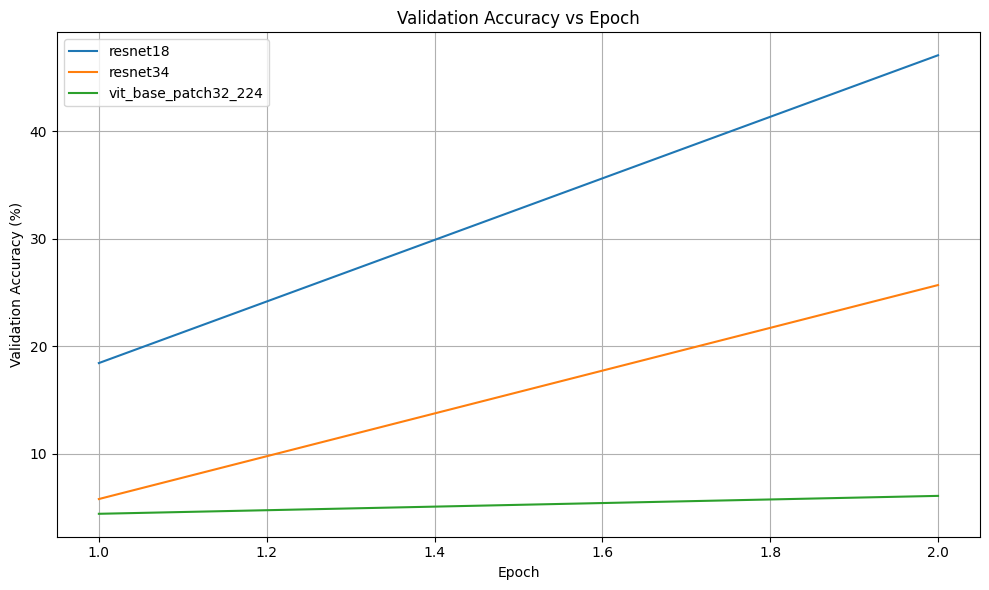

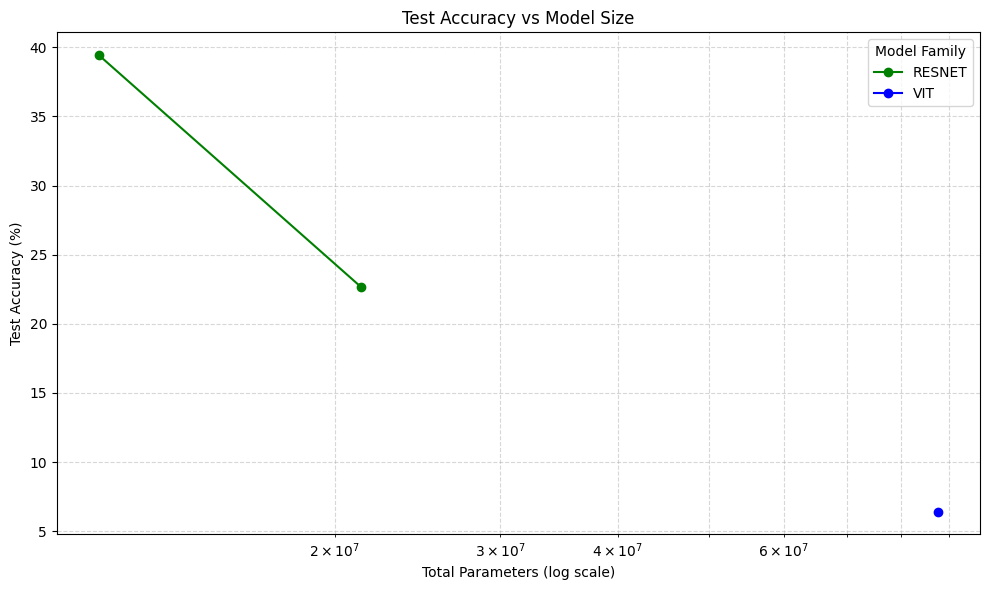

In [ ]:
plot_model_histories(histories)

# Reduce Parameters: Pruning

In [17]:
model = create_model_with_timeout(
		"resnet18", num_classes=102, device=device
	)
model_names_debug = [
	"resnet18",
	"vit_base_patch32_224",
]
for name, module in model.named_modules():
	print(name, type(module))

	

Ignored missing keys: ['fc.weight', 'fc.bias']
Ignored unexpected keys: []
 <class 'timm.models.resnet.ResNet'>
conv1 <class 'torch.nn.modules.conv.Conv2d'>
bn1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
act1 <class 'torch.nn.modules.activation.ReLU'>
maxpool <class 'torch.nn.modules.pooling.MaxPool2d'>
layer1 <class 'torch.nn.modules.container.Sequential'>
layer1.0 <class 'timm.models.resnet.BasicBlock'>
layer1.0.conv1 <class 'torch.nn.modules.conv.Conv2d'>
layer1.0.bn1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
layer1.0.drop_block <class 'torch.nn.modules.linear.Identity'>
layer1.0.act1 <class 'torch.nn.modules.activation.ReLU'>
layer1.0.aa <class 'torch.nn.modules.linear.Identity'>
layer1.0.conv2 <class 'torch.nn.modules.conv.Conv2d'>
layer1.0.bn2 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
layer1.0.act2 <class 'torch.nn.modules.activation.ReLU'>
layer1.1 <class 'timm.models.resnet.BasicBlock'>
layer1.1.conv1 <class 'torch.nn.modules.conv.Conv2d'>
layer1.1.bn1 <clas

# Deformable Convolutions